3D model options test script
============================
This test script is to test implemented features with tertiary structures.

You can also use it to view the different options and how they look.
The function calls are likely to stay the same, but the default plots
may look a little different in the future.

Currently broken
----------------
* nothing that I'm aware of

Notebook set-up
---------------

In [1]:
# This sets plots to display in-line by default
%matplotlib inline
import sys
# Import module, for high-level functions, no additional modules are needed
import plotmapper as MaP


# Creates an HTML button that hides/shows code cells
# Useful for lab notebook reports and research updates
# NOTE: this does not display well on GitHub.
MaP.create_code_button()

Initializing MaP sample
-----------------------
If you have consistently named files, (which you should), you can use a function to create a dictionary of keyword arguments (kwargs). Then, "unpack" the dictionary using the double asterisk.

In [2]:
path = 'data/'
def kwargs(sample):
    kwargs = {"sample": sample,
              "profile": path+sample+"_rnasep_profile.txt",
              "ct": path+"RNaseP.ct",
              "ss": path+"RC_CRYSTAL_STRUCTURE.xrna",
              "rings": path+sample+"-rnasep.corrs",
              "pairs": path+sample+"-rnasep-pairmap.txt",
              "log": path+sample+"_shapemapper_log.txt",
              "dance_prefix": path+sample+"_rnasep",
              "deletions": path+"example-rnasep-deletions.txt",
              "fasta": path+"RNaseP-noSC.fasta",
              "pdb": path+"3dhs_Correct.pdb",
              "pdb_kwargs":{"chain": "A"}}
    return kwargs

example1 = MaP.Sample(**kwargs("example1"))
example2 = MaP.Sample(**kwargs("example2"))
example3 = MaP.Sample(**kwargs("example3"))
example4 = MaP.Sample(**kwargs("example4"))
samples = [example1, example2, example3, example4]

(-10.999877619232853,
 10.999877619232853,
 -10.99810933669334,
 10.970086477469694)

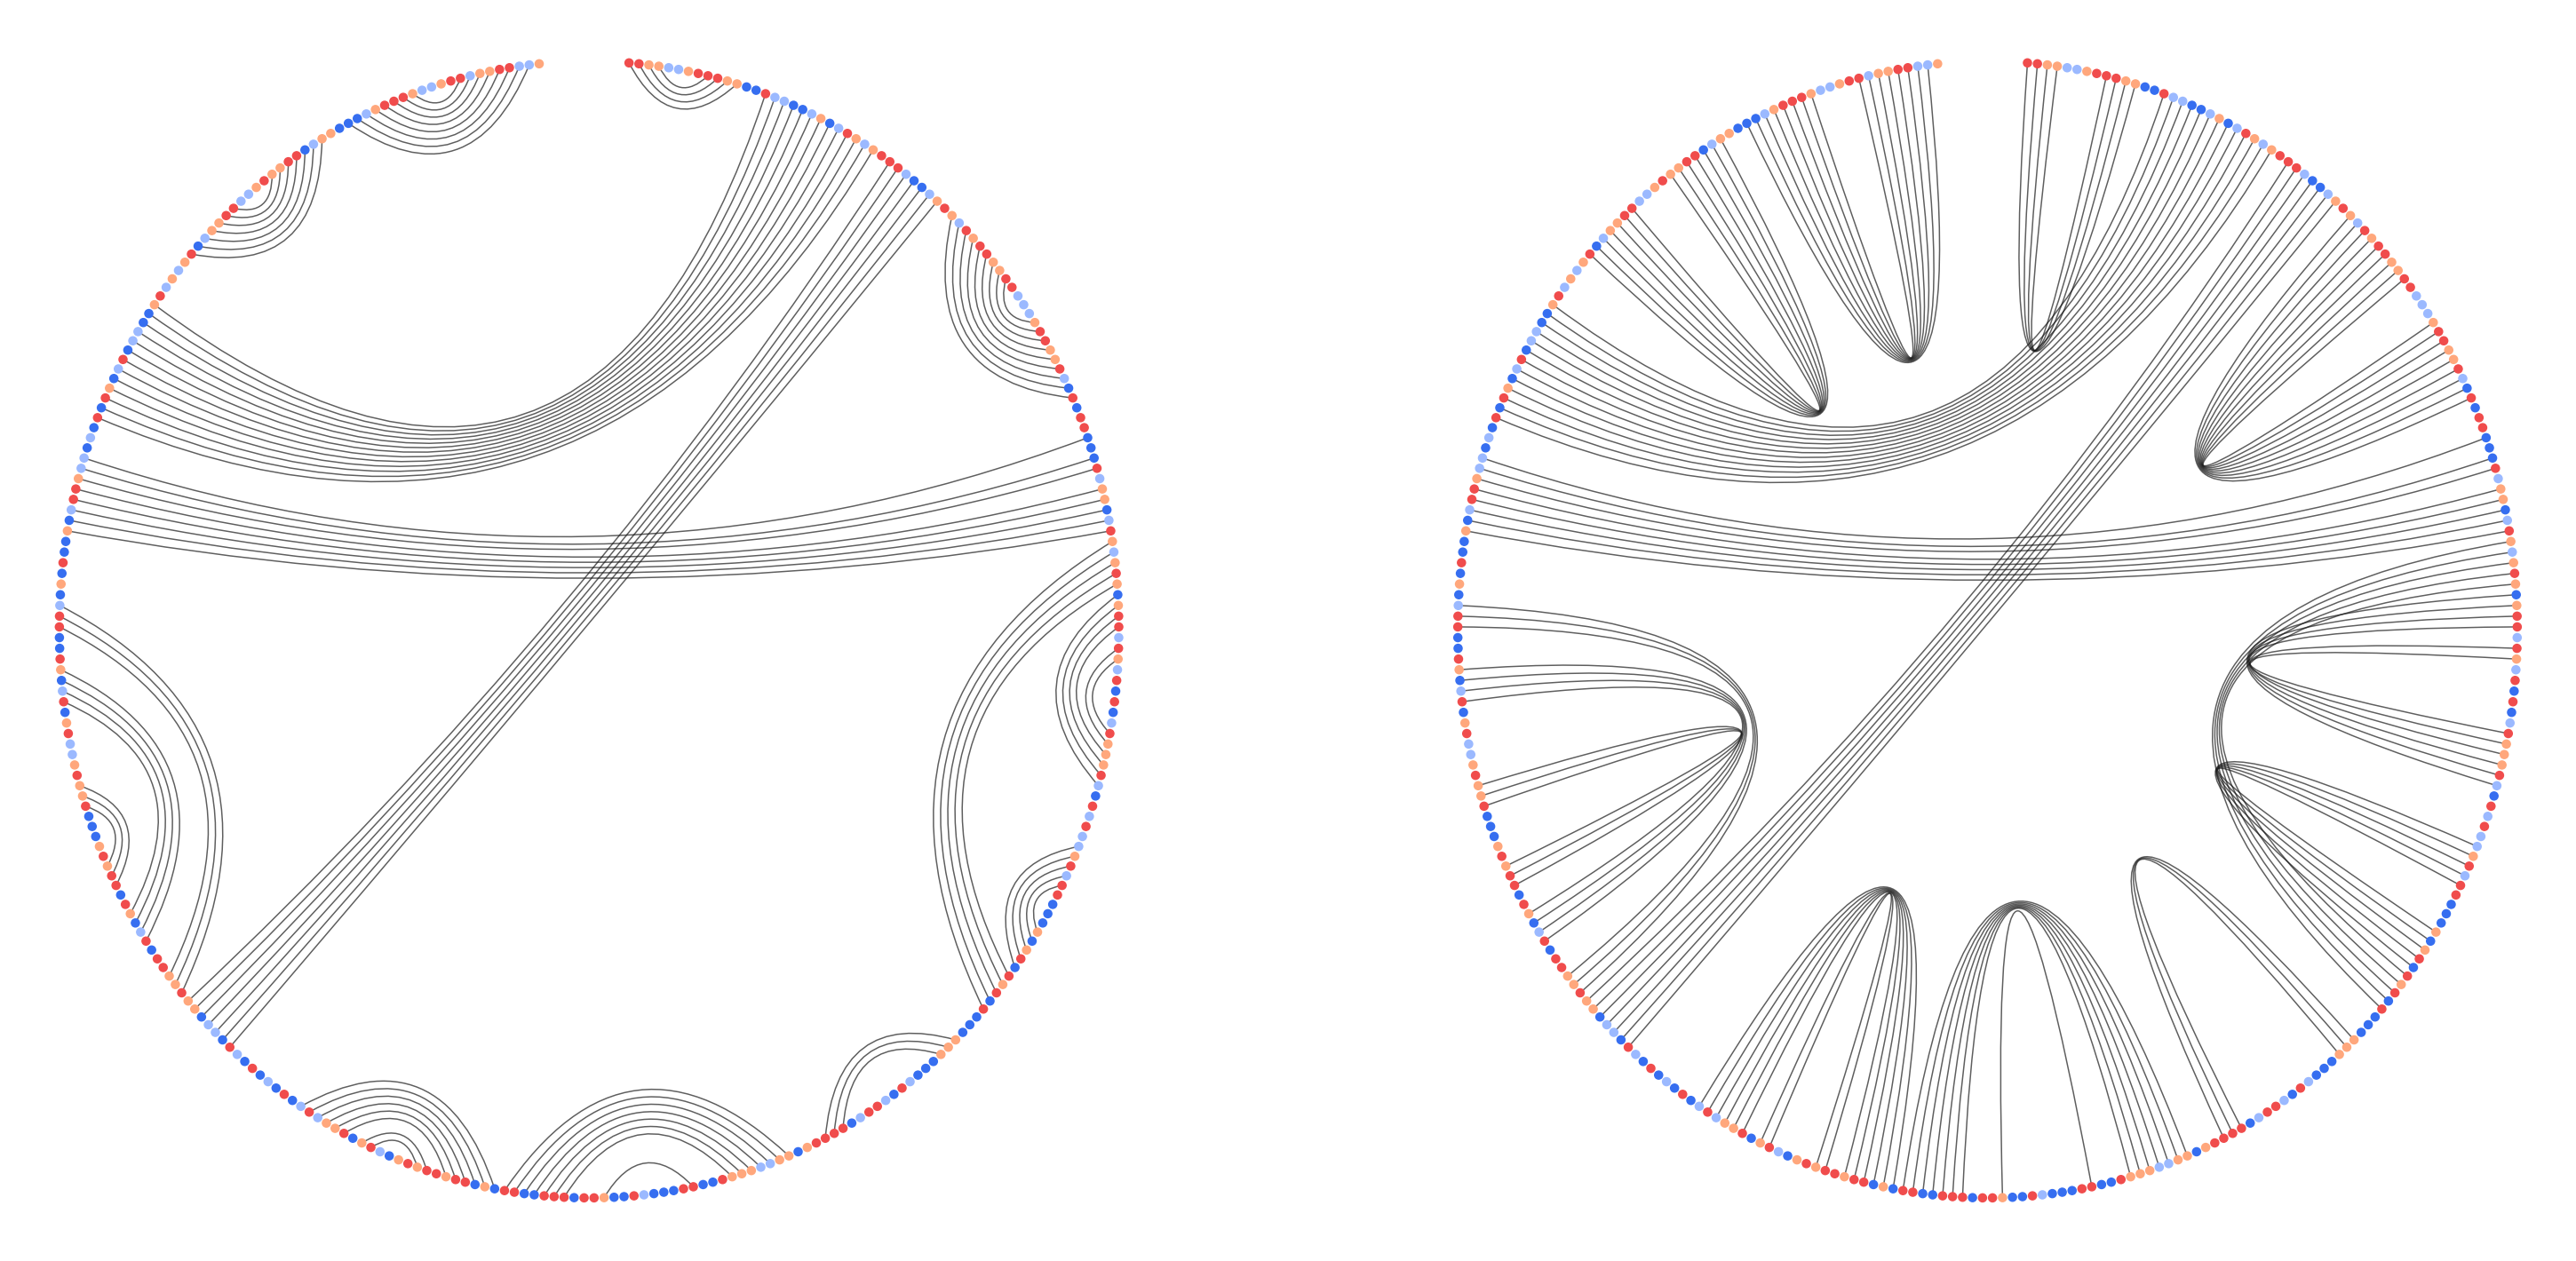

In [9]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Path, PathPatch
import matplotlib.pyplot as plt
from math import sin, cos, pi, degrees, atan2
seq = example1.data["ct"].sequence

x, y = [], []
for i in range(len(seq)):
    theta = 2*pi * (i+4)/(len(seq)+8)
    x.append(sin(theta)*10)
    y.append(cos(theta)*10)
figsize = (len(seq)/(4*pi)*2, len(seq)/(4*pi))
fig, ax = plt.subplots(1, 2, figsize=figsize)

#example2.data["deletions"].filter(example2.data["deletions"], Percentile=0.8)
ij_colors = example2.data["ct"].get_ij_colors()
nuc_colors = example2.data["ct"].get_colorby_sequence()

patches = []
patches2 = []
for i, j, color in zip(*ij_colors):
    x1 = x[i-1]
    y1 = y[i-1]
    x2 = x[j-1]
    y2 = y[j-1]
    cx = (x1+x2)/2
    cy = (y1+y2)/2
    f = (1 - ((j - i) / (len(seq) + 8))) ** 4
    verts = [[x1, y1], [cx*f, cy*f], [x2, y2]]
    verts2 = [[x1, y1], [0, 0], [x2, y2]]
    codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
    patches.append(PathPatch(Path(verts, codes), fc="none", ec=color))
    patches2.append(PathPatch(Path(verts2, codes), fc="none", ec=color))
patches = PatchCollection(patches, match_original=True)
patches2 = PatchCollection(patches2, match_original=True)
ax[0].add_collection(patches)
ax[0].scatter(x, y, marker='o', c=nuc_colors)
ax[0].axis('off')
ax[1].add_collection(patches2)
ax[1].scatter(x, y, marker='o', c=nuc_colors)
ax[1].axis('off')


In [6]:
abs(-30) % 180

30

In [4]:
from plots.new_arc import AP
plot = AP(4, example1.data["ct"].length)
for sample in samples:
    sample.filter_ij("rings", "ct", cdAbove=15, Statistic=23, Sign=0)
    sample.filter_ij("pairs", "ct", paired_only=True)
    plot.add_sample(sample, ct="ct", comp="compct", ij="rings", ij2="pairs", profile="profile", label=sample.sample)

ModuleNotFoundError: No module named 'plots.new_arc'

AttributeError: Unknown property bw_adjust

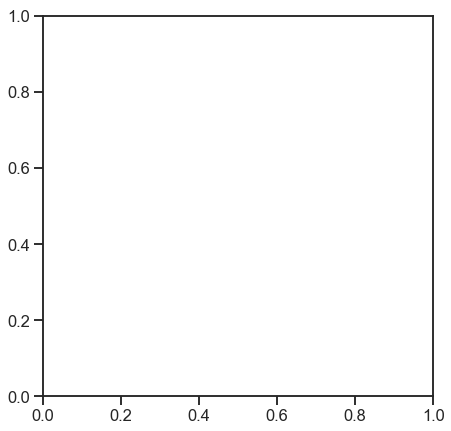

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def plot_reactivity_kde(sample, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(7,7))
    paired = np.array(sample.data["ct"].ct) != 0
    valid = sample.data["profile"].data["Reactivity_profile"] > 0
    sns.kdeplot(sample.data["profile"].data.loc[paired & valid,"Reactivity_profile"],
                bw_adjust=0.6, shade=True, label='SS', ax=ax, log_scale=True)
    sns.kdeplot(sample.data["profile"].data.loc[~paired & valid, "Reactivity_profile"],
                bw_adjust=0.6, shade=True, label='DS', ax=ax, log_scale=True)
    ax.annotate(sample.sample, (0.1, 0.9), xycoords="axes fraction")
    ax.set(xlim=(0.00001,0.5))

plot_reactivity_kde(example1)


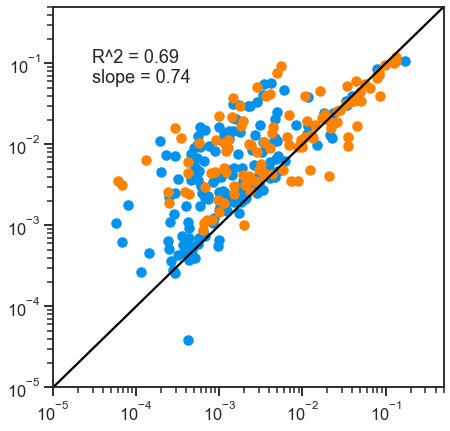

In [ ]:
from scipy import stats
def make_regression(sample, comp_sample, ax=None, colorby="ct",
                    column="Reactivity_profile"):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(7, 7))
    p1 = sample.data["profile"].data[column].copy()
    p2 = comp_sample.data["profile"].data[column].copy()
    notNans = ~np.isnan(p1) & ~np.isnan(p2)
    p1 = p1[notNans]
    p2 = p2[notNans]
    ax.plot([-10, 10], [-10, 10], color='black')
    gradient, _, r_value, _, _ = stats.linregress(p1, p2)
    ax.text(0.1, 0.8, f'R^2 = {r_value**2:.2f}\nslope = {gradient:.2f}',
            transform=ax.transAxes)
    if colorby == "ct":
        paired_list = sample.data["ct"].pairedResidueList()
        paired_mask = np.zeros(sample.data["profile"].length, dtype=bool)
        for i in paired_list:
            paired_mask[i] = True
        paired_mask = paired_mask[notNans]
        unpaired_mask = ~paired_mask
        ax.scatter(p1[paired_mask], p2[paired_mask], label="Paired")
        ax.scatter(p1[unpaired_mask], p2[unpaired_mask], label="Unpaired")
    elif colorby == "nucleotide":
        for nuc in "GUAC":
            sequence = sample.data["profile"].data["Sequence"][notNans]
            nuc_mask = [nt == nuc for nt in sequence]
            color = get_nt_color(nuc)
            ax.scatter(p1[nuc_mask], p2[nuc_mask], label=nuc, color=color)
    else:
        ax.scatter(p1, p2)
    ax.set(xlim=[0.00001, 0.5],
           xscale='log',
           yscale='log',
           ylim=[0.00001, 0.5])

make_regression(example1, example2)

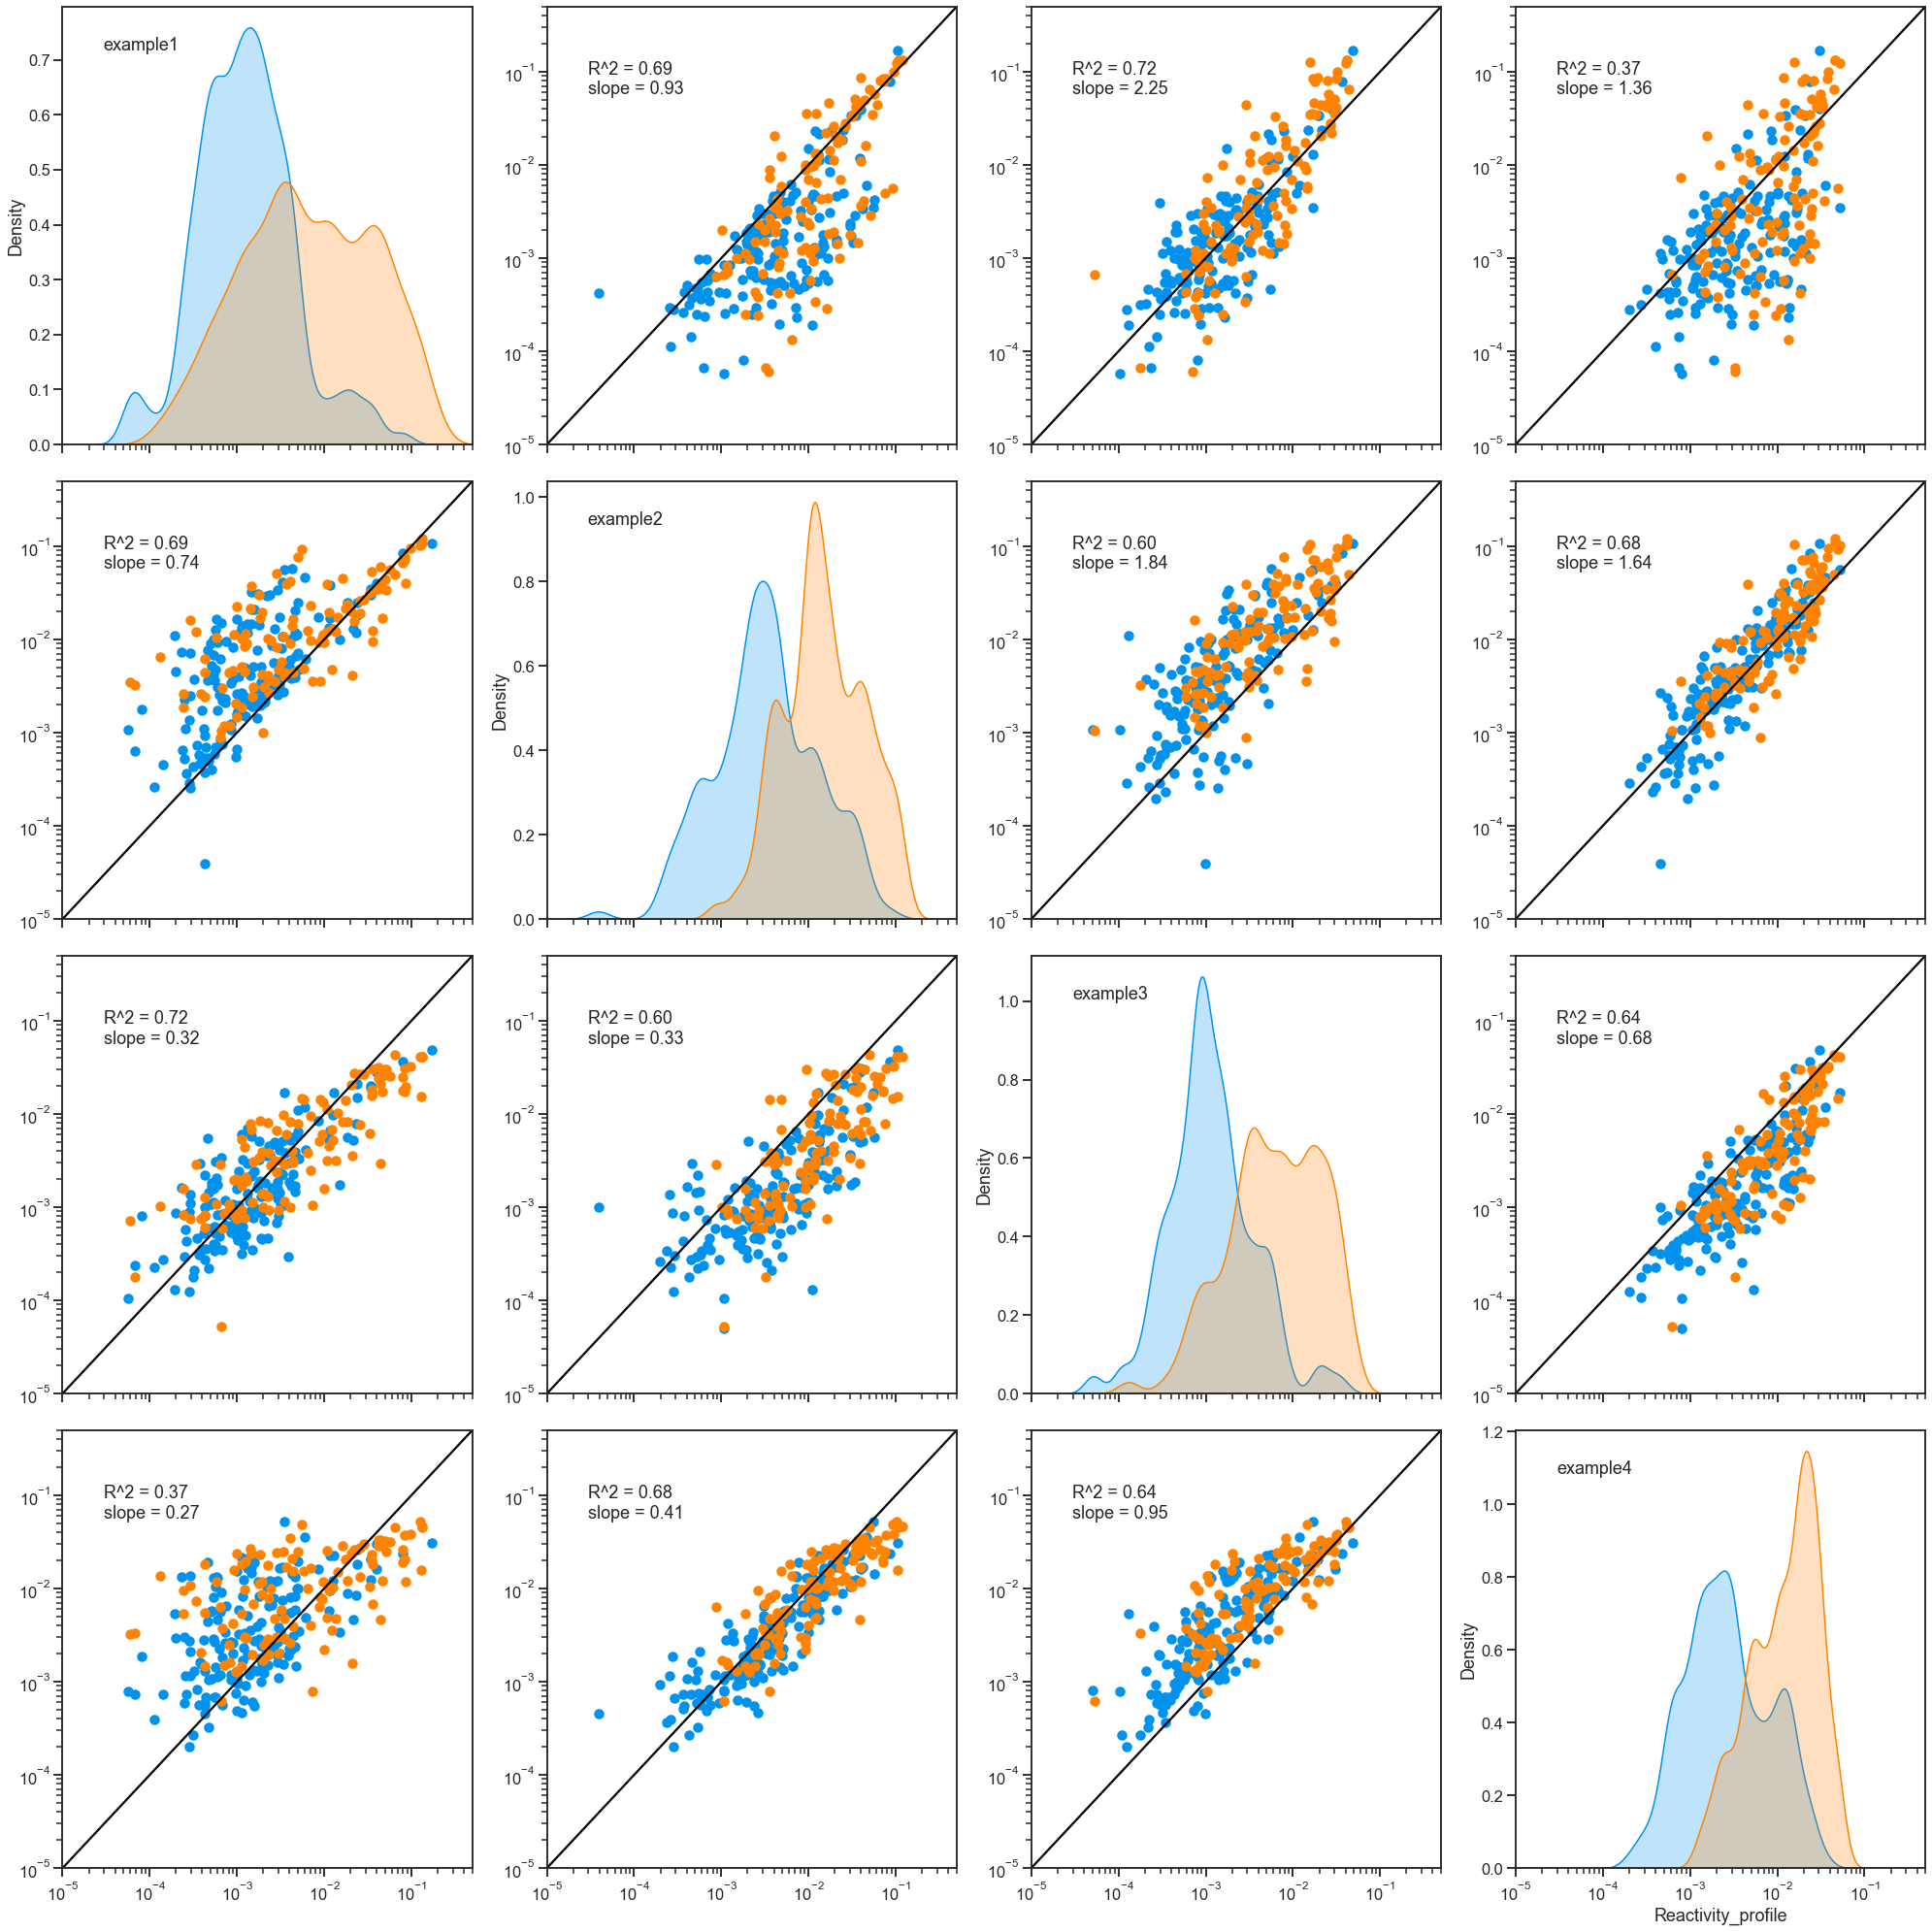

In [ ]:
fig, ax = plt.subplots(4,4,figsize=(28,28), sharex=True)
for i in range(4):
    plot_reactivity_kde(samples[i], ax[i,i])
    for j in [x for x in range(4) if x!=i]:
        make_regression(samples[i], samples[j], ax[j,i])
plt.tight_layout();